# 3 bin Model

- Notebook contains models ran with 3 price catergories instead of 5

- Create a basic nlp model to predict bin price
- Create a basic model using car info to predict bin price

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import re
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import xgboost as xgb

In [2]:
data = pd.read_csv('../data/CleanData3bins.csv')

In [3]:
data = data.drop(columns='Unnamed: 0')

In [4]:
data

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0
...,...,...,...,...,...,...,...,...,...,...
8469,FWD,78378.0,25500.0,Cheap,Only had the X5 for 4 weeks now but so far it ...,2022.0,3.6,6,BMW,18.0
8470,AWD,30909.0,35590.0,Average,When I bought my 2020 Tacoma V6 (3.5L) 4x4 in ...,2019.0,3.6,6,Toyota,18.0
8471,FWD,30186.0,24000.0,Cheap,Everything is great except the rear view camer...,2015.0,2.5,4,INFINITI,23.0
8472,FWD,22309.0,71077.0,Expensive,I have owned smaller SUV\s and Trucks for over...,2020.0,5.7,8,Toyota,15.0


**Review cleaning**
- make a base model for nlp

In [5]:
df = data[['CleanReviews', 'PriceCategory']]

In [6]:
df.head()

,CleanReviews,PriceCategory
0,Virtually nothing has gone wrong with my 2020 ...,Average
1,Stranded today. Could not get to work. Somethi...,Expensive
2,"Excellent road car, quiet, stable, comfortable...",Average
3,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",Cheap
4,I’ve own a 2020 Altima (under 30k miles) for a...,Cheap


In [7]:
rev_index = 100

In [8]:
df['CleanReviews'][rev_index]

'Hands down the best Jeep ever.. would take it over the Santa Fe any day of the week.. there’s no comparison.. performance is excellent.. have 70,000 miles on a 2018 and a 2019.. ac went out on one but warranty covered it🙂🙂, I absolutely love my jeep it’s comfortable reliable and completely rugged I never feel like I’m going to get stranded stuck or be taken down by anything you feel completely safe high up and well compact in this vehicle definitely worth the money I will never change my vehicle make!!! Jeep owner for GOOD!!! , have a 2019 high altitude , love this vehicle so comfortable and smooth love it, first vehicle i have loved driving. love the design and the smooth ride'

**Testing out the patter, make sure it's taking out the unwanted characters**

In [9]:
re.sub("[a-zA-Z]+(?:'[a-z]+)?", '', df['CleanReviews'][rev_index])

'     ..            .. ’  ..   ..  70,000    2018   2019..         🙂🙂,      ’          ’                                  !!!    !!! ,   2019   ,         ,      .       '

# Pre-proccessing

- just lowercase all the reviews, the tfidvectorizer will take care of the rest

In [10]:
df['CleanReviews'] = df['CleanReviews'].str.lower()

<ipython-input-10-f0607efd20df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CleanReviews'] = df['CleanReviews'].str.lower()


In [11]:
df.head()

,CleanReviews,PriceCategory
0,virtually nothing has gone wrong with my 2020 ...,Average
1,stranded today. could not get to work. somethi...,Expensive
2,"excellent road car, quiet, stable, comfortable...",Average
3,"purchased from nye toyota, my first tacoma. lo...",Cheap
4,i’ve own a 2020 altima (under 30k miles) for a...,Cheap


- clean up reviews, 

In [12]:
#stopwords
sw = stopwords.words('english')

# Train, Test,  Split

- Creating a holdout set to use at the very end

In [13]:
X = data['CleanReviews']
y = data['PriceCategory']

In [14]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

# Vectorize

In [16]:
vectorizer = TfidfVectorizer(
    token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
    stop_words=sw,
#     max_df=.95,  # removes words that appear in more than 95% of docs not using either, produces better model
#     min_df=2     # removes words that appear 2 or fewer times
)

In [17]:
X_train.iloc[rev_index]

'The ride is great, Toyota gives comfort and space, very good on gas and good price to own the car all you need is on this vehicle, This car rides nice and runs great it meets all of my driving needs. Would definitely buy another one. I needed a reliable car to get to work. Thank you, I went with the 2017 model due to the new 2018 + models having issues w/ that new 8 speed transmission. This was the last model w/  a bulletproof transmission so far. I hope to pay this car off and be payment free and problem free for the next decade. Always go with Toyota. They are the most reliable by statistics and no one wants to have car troubles.'

In [18]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [19]:
X_train_vec.shape

(5719, 10389)

In [20]:
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)
classifier.score(X_val_vec, y_val)

0.41321447299423175

- not bad score
- only fraction of total reviews are unique reviews
- 41% accuracy seems good considering I am trying to model human language :)

# Features for the car

- testing out different vanilla models
- getting the best one and try to use it with nlp model

In [21]:
data.head()

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0


In [22]:
data['DriveTrain'].value_counts()

FWD    5281
AWD    1801
RWD    1392
Name: DriveTrain, dtype: int64

In [23]:
X = data.drop(columns=['CleanReviews', 'PriceCategory', 'SalePrice'])
y = data['PriceCategory']

**Creating a train test split and a holdout set to use at the end**

In [24]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

**Creating a column transformer to use on models**

In [26]:
num_cols = ['Mileage', 'Year', 'newSize', 'newCyl', 'mpg']
cat_cols = ['DriveTrain', 'newMake']

In [27]:
cat_transformer = OneHotEncoder(drop=['RWD', 'Other'])

In [28]:
num_transformer = MinMaxScaler()

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", num_transformer, num_cols),
    ('cat_trans', cat_transformer, cat_cols)
])

In [30]:
preprocessor.fit_transform(X_train)

<5719x32 sparse matrix of type '<class 'numpy.float64'>'
	with 38788 stored elements in Compressed Sparse Row format>

# Knn

In [31]:
clf_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [32]:
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('knn', KNeighborsClassifier())])

In [33]:
print(f"Train Accuracy: {clf_knn.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_knn.score(X_val, y_val)}")

Train Accuracy: 0.7600979192166463
Test Accuracy: 0.6324069218668065


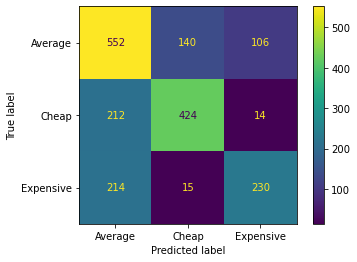

In [34]:
plot_confusion_matrix(clf_knn, X_val, y_val);

# Decision Tree

In [35]:
clf_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [36]:
clf_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [37]:
print(f"Train Accuracy: {clf_dt.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_dt.score(X_val, y_val)}")

Train Accuracy: 1.0
Test Accuracy: 0.6769795490298899


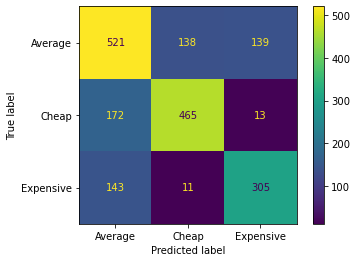

In [38]:
plot_confusion_matrix(clf_dt, X_val, y_val);

# LogReg

In [39]:
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga', random_state=42))
])

In [40]:
clf_lr.fit(X_train, y_train)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('lr',
                 LogisticRegression(multi_class='multinomial', penalty='l1',
                                    random_state=42, solver='saga'))])

In [41]:
print(f"Train Accuracy: {clf_lr.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_lr.score(X_val, y_val)}")

Train Accuracy: 0.6924287462843154
Test Accuracy: 0.6712113266911379


In [42]:
cv_results = cross_validate(clf_lr, X_train, y_train, cv=5, return_train_score=True)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

In [43]:
cv_results['test_score'].mean()

0.6836855838824343

In [44]:
cv_results['train_score'].mean()

0.6934779605640261

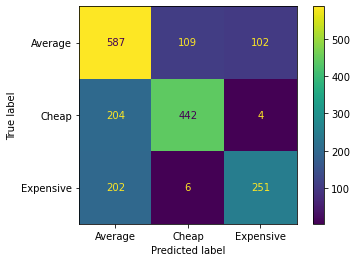

In [45]:
plot_confusion_matrix(clf_lr, X_val, y_val);

# Random Forest

In [46]:
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(max_depth=10, random_state=42))
])

In [47]:
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [48]:
print(f"Train Accuracy: {clf_rf.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_rf.score(X_val, y_val)}")

Train Accuracy: 0.802063297779332
Test Accuracy: 0.724698479286838


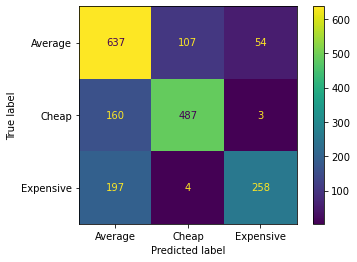

In [49]:
plot_confusion_matrix(clf_rf, X_val, y_val);

# Ridge classifier

In [50]:
clf_rr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rr', RidgeClassifier(solver='sag', random_state=42))
])

In [51]:
clf_rr.fit(X_train, y_train)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('rr', RidgeClassifier(random_state=42, solver='sag'))])

In [52]:
print(f"Train Accuracy: {clf_rr.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_rr.score(X_val, y_val)}")

Train Accuracy: 0.6557090400419654
Test Accuracy: 0.6381751442055584


In [53]:
cv_results_rr = cross_validate(clf_rr, X_train, y_train, cv=5, return_train_score=True)

C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
C:\Users\dcv_2\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warning

In [54]:
cv_results_rr['test_score'].mean()

0.6467887536785175

In [55]:
cv_results_rr['train_score'].mean()

0.6566269154342924

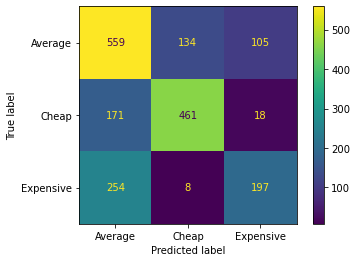

In [56]:
plot_confusion_matrix(clf_rr, X_val, y_val);

# XGBoost

## Best model so far

In [57]:
clf_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(random_state=42, 
                              learning_rate=.1, 
                              max_depth=6,
                             n_estimators=50))
])

In [58]:
clf_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               import...type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
          

In [59]:
print(f"Train Accuracy: {clf_xgb.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_xgb.score(X_val, y_val)}")

Train Accuracy: 0.806609547123623
Test Accuracy: 0.7556371263765076


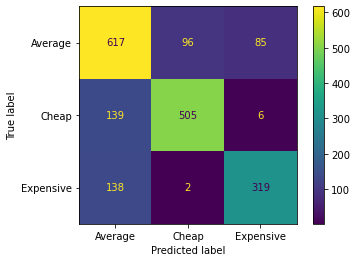

In [60]:
plot_confusion_matrix(clf_xgb, X_val, y_val);

In [61]:
y_val.value_counts()

Average      798
Cheap        650
Expensive    459
Name: PriceCategory, dtype: int64

**Has a hard time with average prices, thinking they are cheap or expensive**